# Merfish to visium registration

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
import glob
import torch

from scipy.stats import rankdata
import nrrd
import time

<IPython.core.display.Javascript object>


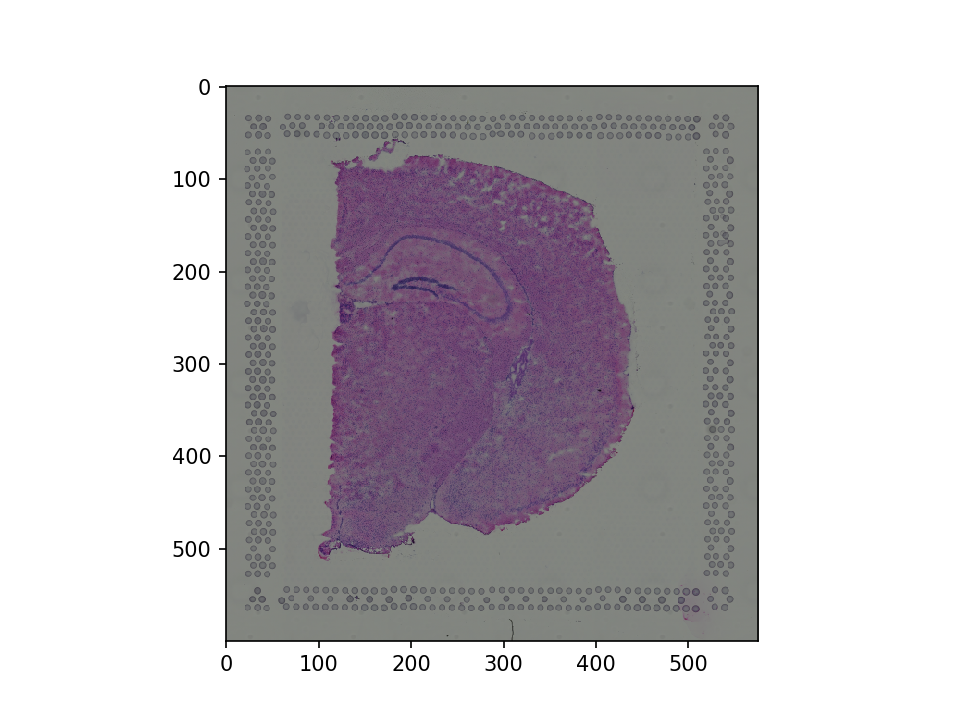

In [2]:
# visium
visium_file = '/mnt/data/merfish/Visium/spatial/tissue_hires_image.png'
visium_file = '/mnt/data/merfish/Visium/spatial/tissue_lowres_image.png'
V = plt.imread(visium_file)
fig,ax = plt.subplots()
ax.imshow(V)

In [3]:
files = glob.glob('/mnt/data/merfish/OneDrive_1_8-5-2021/*metadata*.csv.gz')
files.sort()
files

['/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_metadata_S1R1.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate2_cell_metadata_S1R2.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate3_cell_metadata_S1R3.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate1_cell_metadata_S2R1.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice3_Replicate1_cell_metadata_S3R1.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_Brai

In [4]:
fname = files[-4]

<IPython.core.display.Javascript object>


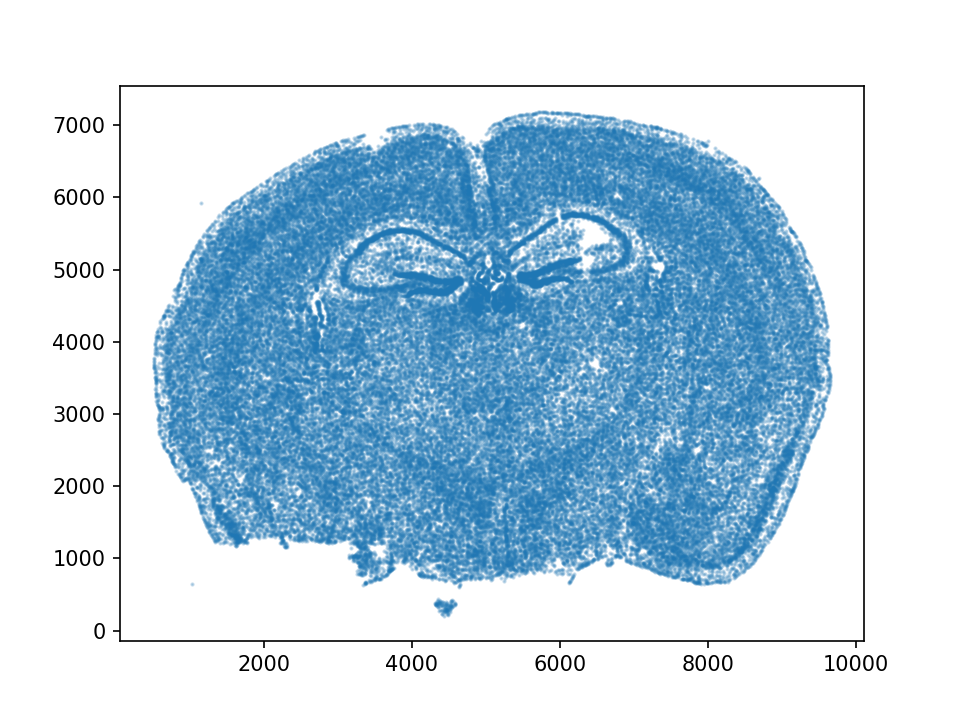

(256, 336)


<IPython.core.display.Javascript object>


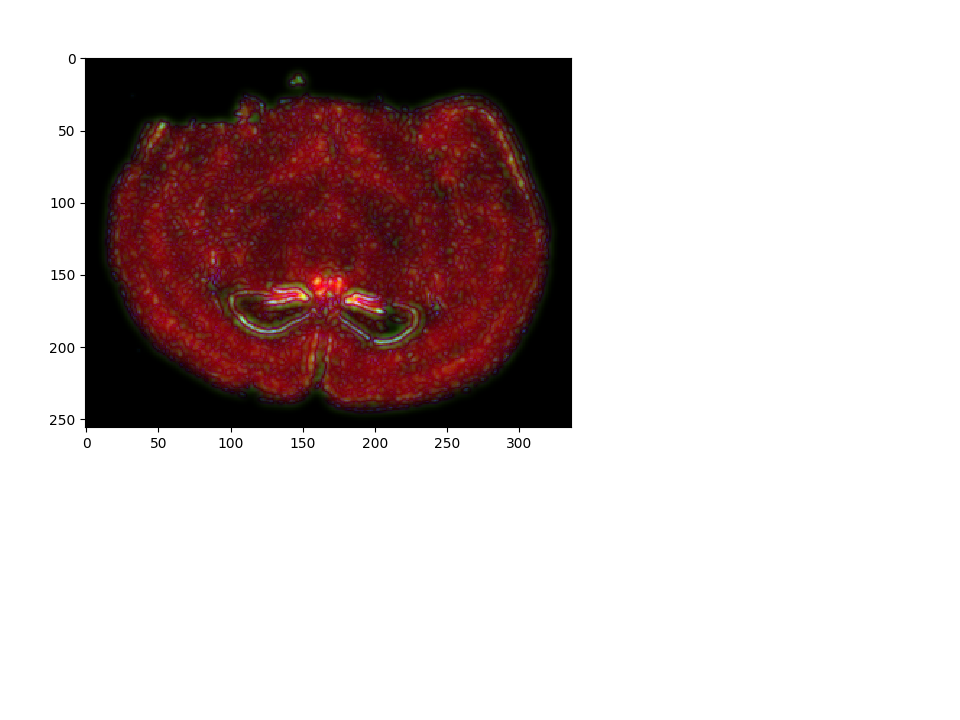

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


In [5]:
names = os.path.splitext(fname)
if names[1] == '.gz':
    names = os.path.splitext(names[0])
outname = names[0] + '_with_structure_id_v02.csv'


df = pd.read_csv(fname.replace('by_gene','metadata'))
x = np.array(df['center_x'])
y = np.array(df['center_y'])
v = np.array(df['volume'])
N = x.shape[0]
mat = np.array([[9.20788192749023E+00, 0E+00, -3.77225189208984E+02],
            [0E+00, 9.20783615112305E+00, 9.39383850097656E+02],
            [0E+00, 0E+00, 1E+00 ]])
mat = np.eye(3)
xy = np.stack((x,y),0)
xy = mat[:2,:2]@xy + mat[:2,-1][:,None]
x,y = xy
f,ax = plt.subplots()
ax.scatter(x,y,s=1,alpha=0.25)
#ax.invert_yaxis()
# what are the units in xy
# they should be microns
# they're probably pixel, the conversion factor is
f.canvas.draw()


# now we want to rasterize
minx = np.min(x)
maxx = np.max(x)
miny = np.min(y)
maxy = np.max(y)
expand = 1.1
minx,maxx = (minx+maxx)/2.0 - (maxx-minx)/2.0*expand, (minx+maxx)/2.0 + (maxx-minx)/2.0*expand
miny,maxy = (miny+maxy)/2.0 - (maxy-miny)/2.0*expand, (miny+maxy)/2.0 + (maxy-miny)/2.0*expand

dx = 50 # I will register to 50 micron atlas
dx = 30
X_ = np.arange(minx,maxx,dx)
Y_ = np.arange(miny,maxy,dx)
X = np.stack(np.meshgrid(X_,Y_))
blur = 0.75 # gaussian std in voxels
blur = 1.0
blur = 2.0
blur = 1.0
blur = 1.5
W = np.zeros((len(Y_),len(X_)))
W1 = np.zeros((len(Y_),len(X_)))
W2 = np.zeros((len(Y_),len(X_)))
print(W.shape)


f,ax = plt.subplots()
count = 0
for x_,y_ in zip(x,y):
    # to speed things up I shoul index
    # to do this I'd have to find row and column indices
    col = np.round((x_ - X_[0])/dx).astype(int)
    row = np.round((y_ - X_[1])/dx).astype(int)
    row0 = np.floor(row-blur*3).astype(int)
    row1 = np.ceil(row+blur*3).astype(int)
    rows = np.arange(row0,row1+1)
    #rows = np.arange(row,row+blur*3+1)
    #rows_ = np.arange(row,row-blur*3-1,-1)
    #rows__ = np.concatenate((rows_[::-1],rows[1:])).astype(int)
    #cols = np.arange(col,col+blur*3+1)
    #cols_ = np.arange(col,col-blur*3-1,-1)
    #cols__ = np.concatenate((cols_[::-1],cols[1:])).astype(int)

    ## this step is incrementing one pixel at a time, it is way way faster
    #I[c_,row,col] += 1.0
    #W[row,col] += 1.0

    k = np.exp( - ( (X[0] - x_)**2 + (X[1] - y_)**2 )/(2.0*(dx*blur*2)**2)  )
    k /= np.sum(k)
    #I[c_] += k 
    W += k
    wavelet = True
    k1 = np.exp( - ( (X[0] - x_)**2 + (X[1] - y_)**2 )/(2.0*(dx*blur)**2)  )
    k1 /= np.sum(k1)
    W1 += (k1-k*wavelet)
    
    k2 = np.exp( - ( (X[0] - x_)**2 + (X[1] - y_)**2 )/(2.0*(dx*blur*0.5)**2)  )
    k2 /= np.sum(k2)
    W2 += (k2-k1*wavelet)

    if not count%10000 or count==(x.shape[0]-1):
        print(f'{count} of {x.shape[0]}')

        ax.cla()
        ax.imshow(np.stack((W/np.max(W),
                            (W1-np.min(W1))/(np.max(W1)-np.min(W1)),
                             (W2-np.min(W2))/(np.max(W2)-np.min(W2))),-1))
        f.canvas.draw()

    count += 1
W1 = np.abs(W1)
W2 = np.abs(W2)
extent = (X_[0],X_[-1],Y_[0],Y_[-1])
ax.cla()
ax.imshow(np.stack((W/np.max(W),W1/np.max(W1),W2/np.max(W2)),-1))
f.canvas.draw()
f.savefig(outname[:-4]+'_image.png')
    

In [6]:
# Now I need to align W and J
M = np.stack((W,W1,W2),0)

In [7]:
# now we will use torch
import torch
from torch.nn.functional import grid_sample
# build an interp function from grid sample
def interp(x,I,phii,**kwargs):
    '''
    Interpolate the image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (2D arrays with first channel storing component)
    '''
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(2):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]


def interp(x,I,phii,**kwargs):
    '''
    Interpolate the image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (3D arrays with first channel storing component)
    
    Make it for 2d
    '''
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(2):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]

In [8]:
# timesteps will be along the first axis
def v_to_phii(xv,v):
    '''
    Inputs: 
        xv -> list of 1D tensors describing locations of sample points
        v -> 5D (nt,3,v0,v1,v2) velocity field
    Output:
        phii (inverse map) computed by method of characteristics

    '''
    XV = torch.stack(torch.meshgrid(xv))
    phii = torch.clone(XV)
    dt = 1.0/v.shape[0]
    for t in range(v.shape[0]):
        Xs = XV - v[t]*dt
        phii = interp(xv,phii-XV,Xs)+Xs
    return phii

In [9]:
def to_A(L,T):
    O = torch.tensor([0.,0.,1.],device=L.device,dtype=L.dtype)
    return torch.cat((torch.cat((L,T[:,None]),1),O[None]))

In [10]:
M.shape,V.shape

((3, 256, 336), (600, 576, 3))

In [11]:
dtype = torch.float64
device = 'cpu'
I = torch.as_tensor(M/np.mean(np.abs(M)),dtype=dtype,device=device) # for label
J = torch.as_tensor(V.transpose(2,0,1),dtype=dtype,device=device)

xI = [torch.as_tensor(Y_,device=device,dtype=dtype),
      torch.as_tensor(X_,device=device,dtype=dtype)]
XI = torch.stack(torch.meshgrid(xI),-1)

dJ = 15.0
xJ = [torch.arange(J.shape[1],device=device,dtype=dtype)*dJ - (J.shape[1]-1)*dJ/2.0,
      torch.arange(J.shape[2],device=device,dtype=dtype)*dJ - (J.shape[2]-1)*dJ/2.0]
XJ = torch.stack(torch.meshgrid(xJ),-1)

extentJ = (xJ[1][0].item()-dJ/2.0,
          xJ[1][-1].item()+dJ/2.0,
          xJ[0][-1].item()+dJ/2.0,
          xJ[0][0].item()-dJ/2.0)


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
def extent_from_x(xJ):
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = ( (xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    return extentJ

<IPython.core.display.Javascript object>


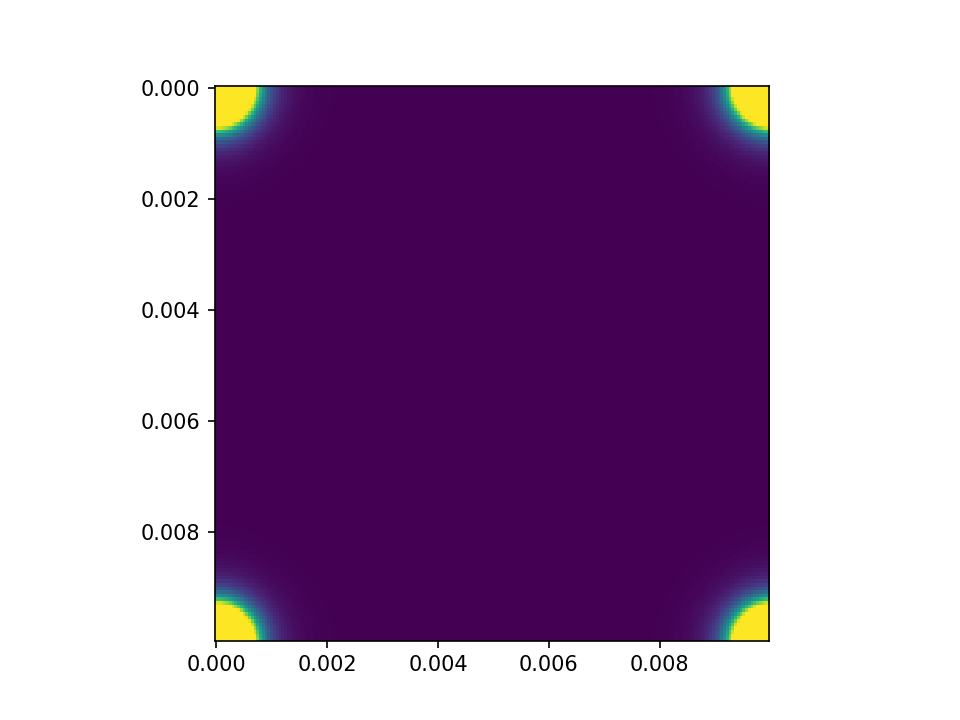

<IPython.core.display.Javascript object>


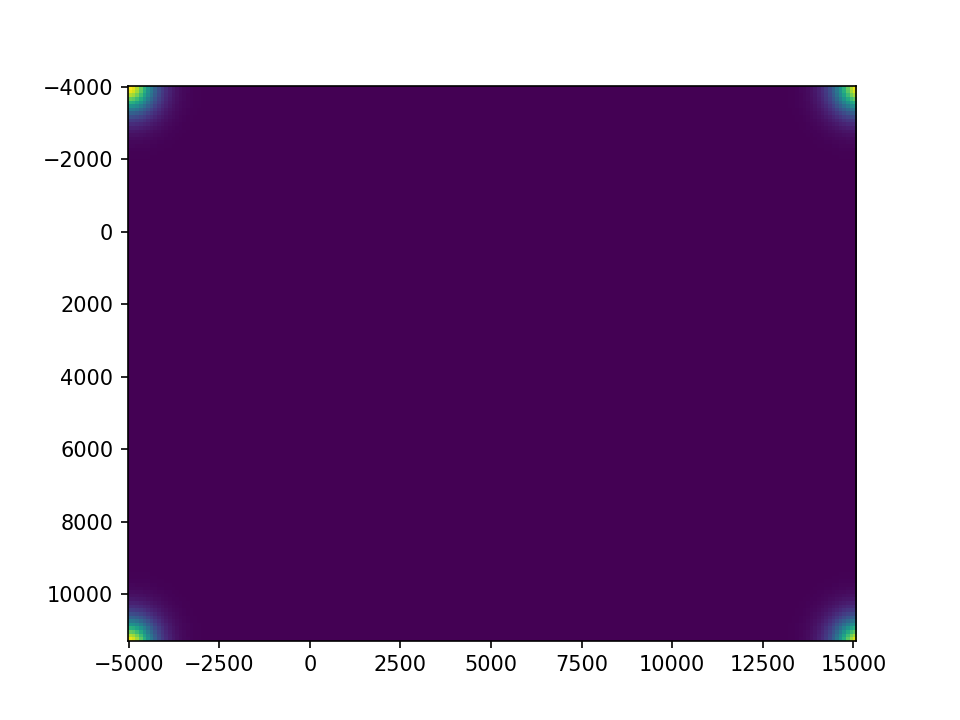

In [13]:
a = 200.0
p = 2.0
expand = 2.0
minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand
xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)]
extentV = extent_from_x(xv)
dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype)
XV = torch.stack(torch.meshgrid(xv),-1)
fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]
extentF = extent_from_x(fv)
FV = torch.stack(torch.meshgrid(fv),-1)
LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)

K = 1.0/LL
fig,ax = plt.subplots()
ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
#fig,ax = plt.subplots()
#ax.imshow(K[0].cpu())
DV = torch.prod(dv)
Ki = torch.fft.ifftn(K).real
fig,ax = plt.subplots()
ax.imshow(Ki,vmin=0.0,extent=extentV)

In [14]:
L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
L.data[0,0] = -1.0
T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
T.data[0] = xI[0][-1]/2.0
T.data[1] = -xI[1][-1]/2.0*1.1

# velocity

nt = 3
v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2]),device=device,dtype=dtype,requires_grad=True)




In [15]:
niter = 1
diffeo_start = 10
epL = 1e-8
epT = 2e0
epV = 1e3

<IPython.core.display.Javascript object>


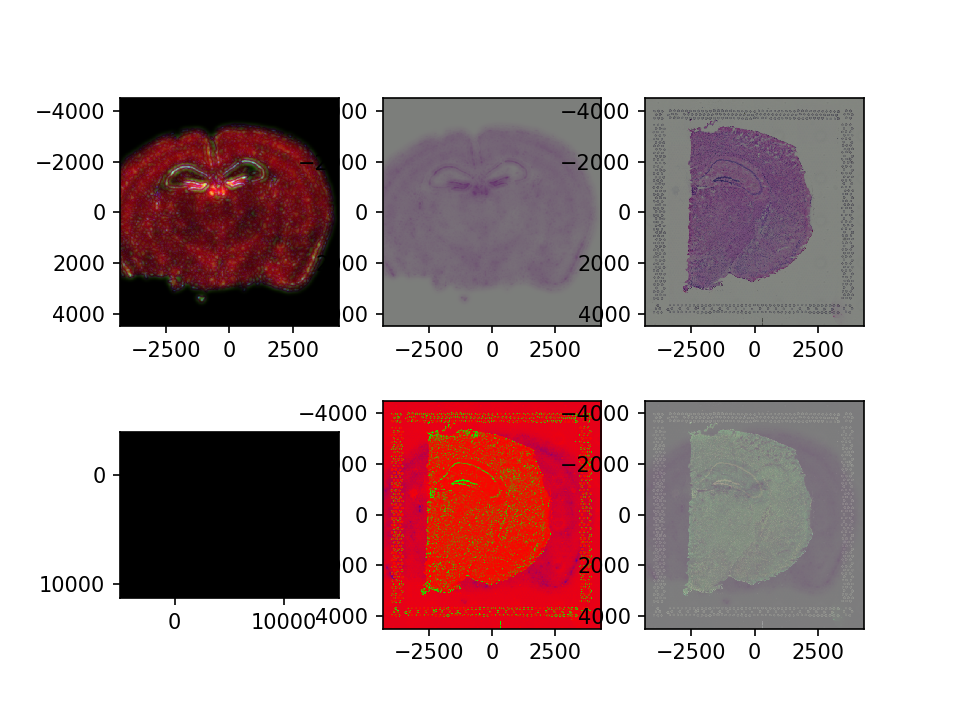

<IPython.core.display.Javascript object>


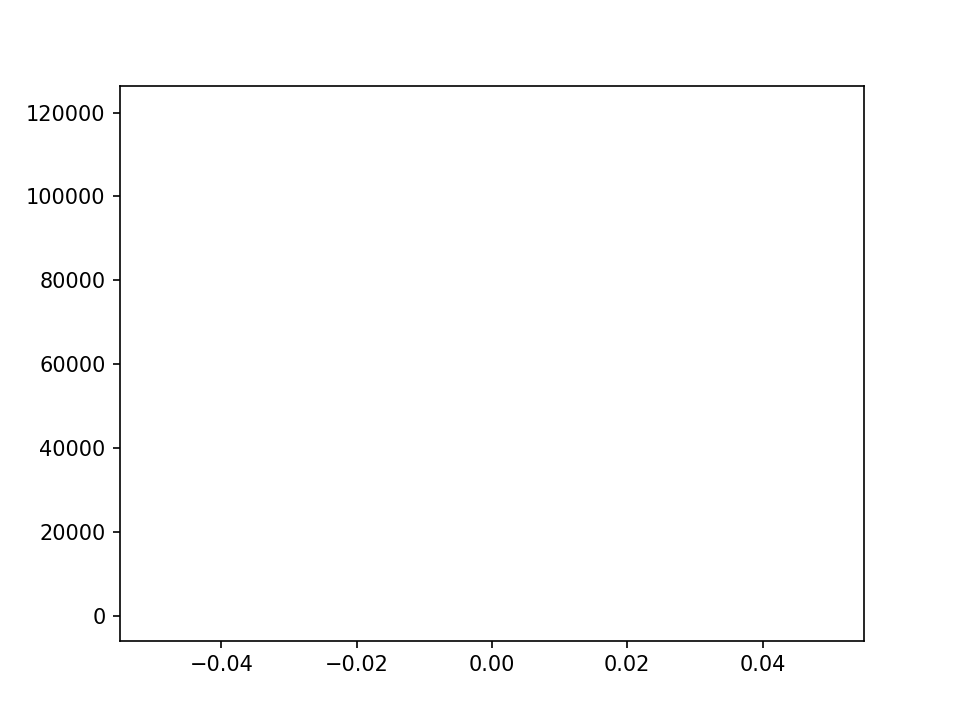

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/autograd/__init__.py:156: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:244.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


In [16]:
WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.6
WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.2
WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.2
sigmaM = 0.1
sigmaB = 0.1
sigmaA = 0.1
sigmaR = 1e4
fig,ax = plt.subplots(2,3)
ax = ax.ravel()
figE,axE = plt.subplots()
Esave = []

try:
    L.grad.zero_()
except:
    pass
try:
    T.grad.zero_()
except:
    pass
for it in range(niter):
    # make A
    A = to_A(L,T)
    # Ai
    Ai = torch.linalg.inv(A)
    # transform sample points
    Xs = (Ai[:2,:2]@XJ[...,None])[...,0] + Ai[:2,-1]    
    # now diffeo, not semilagrange here
    for t in range(nt-1,-1,-1):
        Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt       
    
    # transform image
    AI = interp(xI,I,Xs.permute(2,0,1))
    
    # transform the contrast
    B = torch.ones(1+AI.shape[0],AI.shape[1]*AI.shape[2],device=AI.device,dtype=AI.dtype)
    B[1:] = AI.reshape(AI.shape[0],-1)
    with torch.no_grad():    
        BB = B@(B*WM.ravel()).T
        BJ = B@((J*WM).reshape(J.shape[0],J.shape[1]*J.shape[2])).T
        small = 0.1
        coeffs = torch.linalg.solve(BB + small*torch.eye(BB.shape[0],device=BB.device,dtype=BB.dtype),BJ)
    fAI = ((B.T@coeffs).T).reshape(J.shape)
    
    # objective function
    EM = torch.sum((fAI - J)**2*WM)/2.0/sigmaM**2
    ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
    E = EM + ER
    Esave.append( (E.item(), EM.item(), ER.item()) )
    # gradient update
    E.backward()
    with torch.no_grad():
        L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
        T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad
        
        L.grad.zero_()
        T.grad.zero_()
        
        # v grad
        vgrad = v.grad
        # smooth it
        vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2))*K[...,None],dim=(1,2)).real
        if it >= diffeo_start:
            v -= vgrad*epV
        v.grad.zero_()
        
    
    # update weights
    if not it%5:
        with torch.no_grad():
            # M step for these params
            muA = torch.sum(WA*J,dim=(-1,-2))/torch.sum(WA)
            muB = torch.sum(WB*J,dim=(-1,-2))/torch.sum(WB)
            if it == 0:
                muA = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.3
                muB = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.6
            W = torch.stack((WM,WA,WB))
            pi = torch.sum(W,dim=(1,2))
            pi += torch.max(pi)*1e-3
            pi /= torch.sum(pi)
            
            # now the E step, update the weights
            WM = pi[0]* torch.exp( -torch.sum((fAI - J)**2,0)/2.0/sigmaM**2 )/np.sqrt(2.0*np.pi*sigmaM**2)**J.shape[0]
            WA = pi[1]* torch.exp( -torch.sum((muA[...,None,None] - J)**2,0)/2.0/sigmaA**2 )/np.sqrt(2.0*np.pi*sigmaA**2)**J.shape[0]
            WB = pi[2]* torch.exp( -torch.sum((muB[...,None,None] - J)**2,0)/2.0/sigmaB**2 )/np.sqrt(2.0*np.pi*sigmaB**2)**J.shape[0]
            WS = WM+WB+WA
            WS += torch.max(WS)*1e-3
            WM /= WS
            WB /= WS
            WA /= WS
            
        

    
    # draw
    if not it%10:
        ax[0].cla()
        ax[0].imshow(((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
        ax[1].cla()    
        ax[1].imshow(fAI.permute(1,2,0).clone().detach().cpu(),extent=extentJ)

        ax[5].cla()
        ax[5].imshow((fAI - J).permute(1,2,0).clone().detach().cpu()*0.5+0.5,extent=extentJ)

        ax[2].cla()
        ax[2].imshow(J.permute(1,2,0).cpu(),extent=extentJ)

        ax[4].cla()
        ax[4].imshow(torch.stack((WM,WA,WB),-1).clone().detach().cpu(),extent=extentJ)



        toshow = v[0].clone().detach().cpu()
        toshow /= torch.max(torch.abs(toshow))
        toshow = toshow*0.5+0.5
        toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
        ax[3].cla()
        ax[3].imshow(toshow,extent=extentV)

        axE.cla()
        axE.plot(Esave)


        fig.canvas.draw()
        figE.canvas.draw()
    

In [17]:
# we want allen, merfish, and visium
# we could use one as an intermediary, rather than all pairs.
# jean has olfactoroy bulb datasets.
# daniel add landmarks to update this

In [18]:
torch.amax(AI,dim=(1,2))

tensor([9.3230, 3.9941, 5.2156], dtype=torch.float64, grad_fn=<AmaxBackward0>)

In [19]:
torch.max(v)

tensor(0., dtype=torch.float64, grad_fn=<MaxBackward1>)

<IPython.core.display.Javascript object>


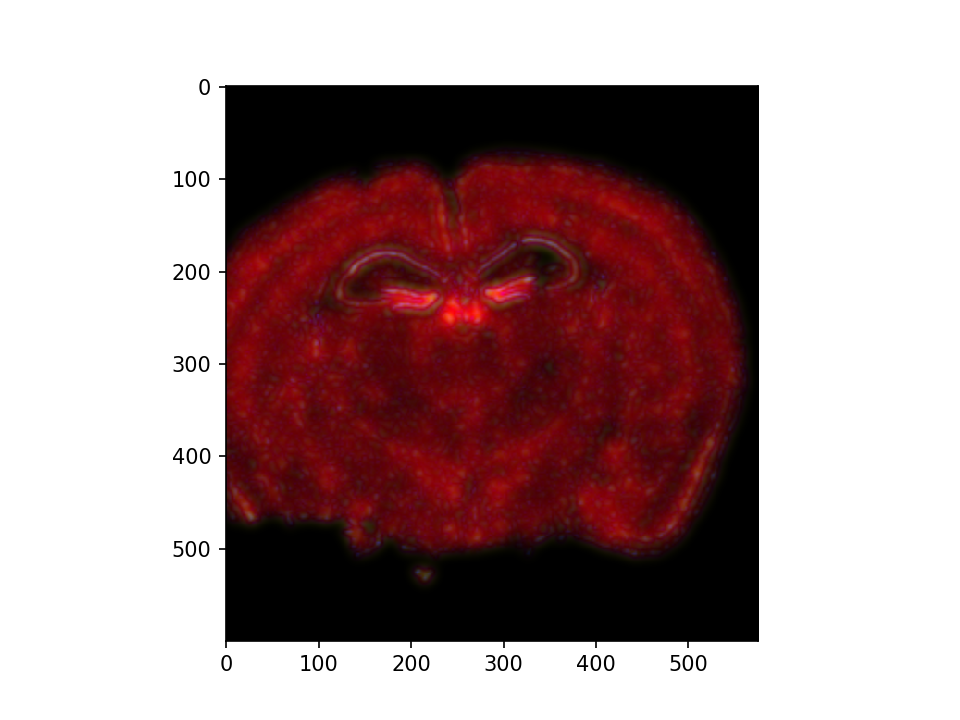

In [20]:
f,ax = plt.subplots()
ax.imshow((AI/torch.max(AI)).permute(1,2,0).detach().clone().cpu().numpy())

In [21]:
fAI-J

tensor([[[-0.0204, -0.0165, -0.0165,  ..., -0.0126, -0.0126, -0.0126],
         [-0.0165, -0.0165, -0.0165,  ..., -0.0126, -0.0126, -0.0126],
         [-0.0204, -0.0204, -0.0204,  ..., -0.0126, -0.0126, -0.0126],
         ...,
         [-0.0204, -0.0204, -0.0204,  ..., -0.0204, -0.0204, -0.0165],
         [-0.0165, -0.0204, -0.0204,  ..., -0.0204, -0.0165, -0.0204],
         [-0.0204, -0.0204, -0.0204,  ..., -0.0204, -0.0204, -0.0204]],

        [[-0.0224, -0.0224, -0.0224,  ..., -0.0184, -0.0184, -0.0184],
         [-0.0224, -0.0224, -0.0224,  ..., -0.0184, -0.0184, -0.0184],
         [-0.0224, -0.0224, -0.0263,  ..., -0.0184, -0.0184, -0.0184],
         ...,
         [-0.0263, -0.0263, -0.0263,  ..., -0.0263, -0.0263, -0.0263],
         [-0.0224, -0.0263, -0.0263,  ..., -0.0263, -0.0224, -0.0224],
         [-0.0263, -0.0263, -0.0263,  ..., -0.0263, -0.0263, -0.0224]],

        [[-0.0134, -0.0134, -0.0134,  ..., -0.0095, -0.0095, -0.0095],
         [-0.0134, -0.0134, -0.0095,  ..., -0

In [22]:
dI = [x[1]-x[0] for x in xI]
extentI = [xI[1][0]-dI[1]/2.0, xI[1][-1]+dI[1]/2.0, xI[0][-1]+dI[0]/2.0, xI[0][0]-dI[0]/2.0]
dJ = [x[1]-x[0] for x in xJ]
extentJ = [xJ[1][0]-dJ[1]/2.0, xJ[1][-1]+dJ[1]/2.0, xJ[0][-1]+dJ[0]/2.0, xJ[0][0]-dJ[0]/2.0]

In [27]:
I.shape,[len(x) for x in xI]

(torch.Size([3, 256, 336]), [256, 336])

In [28]:
# save the images as an NPZ and do landmarking
np.savez('images_to_landmark.npz',I=I.permute(1,2,0).cpu().numpy(),J=J.permute(1,2,0).cpu().numpy(),xI=np.array([x.cpu().numpy() for x in xI],dtype=object),
         xJ=np.array([x.cpu().numpy() for x in xJ],dtype=object))

In [23]:
asdf

NameError: name 'asdf' is not defined

In [ ]:
# write them in yx
pointsI = np.array([[6730.0, 4876.0],
                   [817.0,5046.0],
                   [1101,6883],
                   [5240,6913],
                   [4894,5539], # m3dial dentate
                   [5787,6256],
                   [5133,6211], # lateral superior inner dentate
                   [5401,5494], # medial dentate
                   [5604,6793]])
# this is the outside of the dentate, 5163,6166
pointsJ = np.array([[-3141.0,-2460.0],
                   [2874.0,-2537.0],
                   [2466,-927],
                   [-880,298],
                   [-1193,-1579],
                   [-2029,-1310],
                   [-1289,-697],
                    [-1289,-2307],[-1801,-391]])

In [ ]:
# let's place some landmarks and continue
fig,ax = plt.subplots(1,2)
ax[0].imshow((I/I.max()).permute(1,2,0).cpu(), extent=extentI)
ax[1].imshow((J).permute(1,2,0).cpu(), extent=extentJ)

ax[0].scatter(pointsI[:,1],pointsI[:,0])
ax[1].scatter(pointsJ[:,1],pointsJ[:,0])
for i in range(pointsI.shape[0]):
    ax[0].text(pointsI[i,1],pointsI[i,0],f'{i}')
    ax[1].text(pointsJ[i,1],pointsJ[i,0],f'{i}')

In [ ]:
niter = 1000
diffeo_start = 20
epL = 1e-9
epT = 2e-1
epV = 5e2

L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
L.data[0,0] = -1.0
T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
T.data[0] = xI[0][-1]/2.0
T.data[1] = -xI[1][-1]/2.0*1.1

# velocity
a = 500.0
p = 3.0
expand = 2.0
minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand
xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)]
extentV = extent_from_x(xv)
dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype)
XV = torch.stack(torch.meshgrid(xv),-1)
fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]
extentF = extent_from_x(fv)
FV = torch.stack(torch.meshgrid(fv),-1)
LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)

K = 1.0/LL
fig,ax = plt.subplots()
ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
#fig,ax = plt.subplots()
#ax.imshow(K[0].cpu())
DV = torch.prod(dv)
Ki = torch.fft.ifftn(K).real
fig,ax = plt.subplots()
ax.imshow(Ki,vmin=0.0,extent=extentV)


nt = 3
v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2]),device=device,dtype=dtype,requires_grad=True)





WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.6
WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.2
WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.2
pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)
sigmaM = 0.1
sigmaB = 0.1
sigmaA = 0.1
sigmaR = 1e5
sigmaP = 2e0
fig,ax = plt.subplots(2,3)
ax = ax.ravel()
figE,axE = plt.subplots()
Esave = []

try:
    L.grad.zero_()
except:
    pass
try:
    T.grad.zero_()
except:
    pass
for it in range(niter):
    # make A
    A = to_A(L,T)
    # Ai
    Ai = torch.linalg.inv(A)
    # transform sample points
    Xs = (Ai[:2,:2]@XJ[...,None])[...,0] + Ai[:2,-1]    
    # now diffeo, not semilagrange here
    for t in range(nt-1,-1,-1):
        Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
    # and points
    pointsIt = torch.clone(pointsI)
    for t in range(nt):
        pointsIt += interp(xv,v[t].permute(2,0,1),pointsIt.T[...,None])[...,0].T/nt
    pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T
    
    # transform image
    AI = interp(xI,I,Xs.permute(2,0,1))
    
    # transform the contrast
    B = torch.ones(1+AI.shape[0],AI.shape[1]*AI.shape[2],device=AI.device,dtype=AI.dtype)
    B[1:] = AI.reshape(AI.shape[0],-1)
    with torch.no_grad():    
        BB = B@(B*WM.ravel()).T
        BJ = B@((J*WM).reshape(J.shape[0],J.shape[1]*J.shape[2])).T
        small = 0.1
        coeffs = torch.linalg.solve(BB + small*torch.eye(BB.shape[0],device=BB.device,dtype=BB.dtype),BJ)
    fAI = ((B.T@coeffs).T).reshape(J.shape)
    
    # objective function
    EM = torch.sum((fAI - J)**2*WM)/2.0/sigmaM**2
    ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
    EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
    E = EM + ER + EP
    Esave.append( (E.item(), EM.item(), ER.item(), EP.item()) )
    # gradient update
    E.backward()
    with torch.no_grad():
        L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
        T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad
        
        L.grad.zero_()
        T.grad.zero_()
        
        # v grad
        vgrad = v.grad
        # smooth it
        vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2))*K[...,None],dim=(1,2)).real
        if it >= diffeo_start:
            v -= vgrad*epV
        v.grad.zero_()
        
    
    # update weights
    if not it%5:
        with torch.no_grad():
            # M step for these params
            muA = torch.sum(WA*J,dim=(-1,-2))/torch.sum(WA)
            muB = torch.sum(WB*J,dim=(-1,-2))/torch.sum(WB)
            if it == 0:
                muA = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.3
                muB = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.6
            W = torch.stack((WM,WA,WB))
            pi = torch.sum(W,dim=(1,2))
            pi += torch.max(pi)*1e-3
            pi /= torch.sum(pi)
            
            # now the E step, update the weights
            WM = pi[0]* torch.exp( -torch.sum((fAI - J)**2,0)/2.0/sigmaM**2 )/np.sqrt(2.0*np.pi*sigmaM**2)**J.shape[0]
            WA = pi[1]* torch.exp( -torch.sum((muA[...,None,None] - J)**2,0)/2.0/sigmaA**2 )/np.sqrt(2.0*np.pi*sigmaA**2)**J.shape[0]
            WB = pi[2]* torch.exp( -torch.sum((muB[...,None,None] - J)**2,0)/2.0/sigmaB**2 )/np.sqrt(2.0*np.pi*sigmaB**2)**J.shape[0]
            WS = WM+WB+WA
            WS += torch.max(WS)*1e-3
            WM /= WS
            WB /= WS
            WA /= WS
            
        

    
    # draw
    if not it%10:
        ax[0].cla()
        ax[0].imshow(((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
        ax[0].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
        ax[1].cla()    
        ax[1].imshow(fAI.permute(1,2,0).clone().detach().cpu(),extent=extentJ)
        ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())

        ax[5].cla()
        ax[5].imshow((fAI - J).permute(1,2,0).clone().detach().cpu()*0.5+0.5,extent=extentJ)
        ax[5].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
        ax[5].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
        
        ax[2].cla()
        ax[2].imshow(J.permute(1,2,0).cpu(),extent=extentJ)
        ax[2].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())

        ax[4].cla()
        ax[4].imshow(torch.stack((WM,WA,WB),-1).clone().detach().cpu(),extent=extentJ)



        toshow = v[0].clone().detach().cpu()
        toshow /= torch.max(torch.abs(toshow))
        toshow = toshow*0.5+0.5
        toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
        ax[3].cla()
        ax[3].imshow(toshow,extent=extentV)

        axE.cla()
        axE.plot(Esave)
        axE.legend(['E','EM','ER','EP'])


        fig.canvas.draw()
        figE.canvas.draw()
    

In [ ]:
# now transform the image

In [ ]:
fig,ax = plt.subplots()
ax.imshow(((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)

In [ ]:
fig,ax = plt.subplots()
ax.imshow(fAI.clone().detach().permute(1,2,0).cpu(),extent=extentJ)

In [ ]:
fig,ax = plt.subplots()
ax.imshow(J.permute(1,2,0).cpu(),extent=extentJ)

In [ ]:
nstripe = 2000
stripe = XJ[...,0]%nstripe > nstripe/2
fig,ax = plt.subplots()
ax.imshow((J*stripe + fAI*(1-stripe.float())).permute(1,2,0).clone().detach())

In [ ]:
# next steps
# 1. let's try the second visium dataset, it has more missing data, but is likely a closer section plane
# 2. we should examine the gene expression alignment too.  At each spot, we look at cells in that region, 
#    and sum up gene expression, do we see a good correlation among genes that are sequenced in both types.
# note likely visium is like a noisy version of the merfish. differences in efficiency mean we cannot exactly 
# count the number or rnas.

In [ ]:
# how is this related to KL distances. its related to correlations.